In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Preparing The Data

In [26]:
import pathlib
data_dir = "/home/vignesh/Transfer-Learning-ResNet-Keras/images"
# data_dir = tf.keras.utils.get_file('images', origin=dataset_url, untar=True)flower_photos
data_dir = pathlib.Path(data_dir)

In [46]:
print(data_dir)

/home/vignesh/Transfer-Learning-ResNet-Keras/images


/home/vignesh/Transfer-Learning-ResNet-Keras/images/sharper/image_2024-02-21_17-22-29.png
(640, 480)


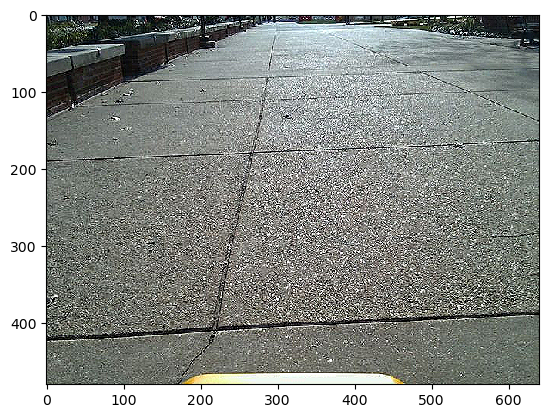

In [47]:
from PIL import Image
sharp_images = list(data_dir.glob('sharper/*'))  # Adjust 'sharp/*' to match your directory structure
print(sharp_images[0])  # Prints the path of the first sharp image

# To open and display the first sharp image
image_path = str(sharp_images[0])
image = Image.open(image_path)
print(image.size)
plt.imshow(image)
plt.show()

In [48]:
img_height,img_width=150,150
batch_size=8
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9830 files belonging to 6 classes.
Using 7864 files for training.


In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9830 files belonging to 6 classes.
Using 1966 files for validation.


In [50]:
class_names = train_ds.class_names
print(class_names)

['100', '20', '40', '60', '80', 'sharper']


/tmp/ipykernel_4047/1657760902.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i + 1)


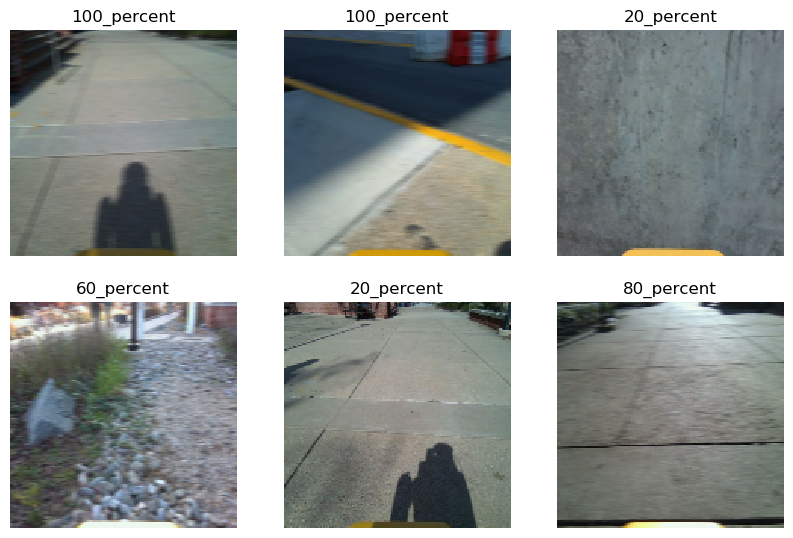

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(3):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Training The Model


In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(150, 150, 3),
    pooling='avg',  
    weights='imagenet'
)
for layer in pretrained_model.layers:
    layer.trainable = False
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dropout(0.3))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.3))  
resnet_model.add(Dense(6, activation='softmax'))




In [35]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 24639878 (93.99 MB)
Trainable params: 1052

In [36]:
# resnet_model.compile(optimizer=Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
from tensorflow.keras.optimizers.schedules import ExponentialDecay
initial_learning_rate = 0.001

# Learning rate decay configuration
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,  
    decay_rate=0.96,    
    staircase=True)   

optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer
resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [37]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


983/983 [==============================] - 125s 126ms/step - loss: 0.8498 - accuracy: 0.6451 - val_loss: 0.4567 - val_accuracy: 0.8108
Epoch 2/10
983/983 [==============================] - 122s 124ms/step - loss: 0.5651 - accuracy: 0.7472 - val_loss: 0.4459 - val_accuracy: 0.8159
Epoch 3/10
983/983 [==============================] - 126s 128ms/step - loss: 0.4986 - accuracy: 0.7878 - val_loss: 0.3995 - val_accuracy: 0.8454
Epoch 4/10
983/983 [==============================] - 127s 130ms/step - loss: 0.4831 - accuracy: 0.7927 - val_loss: 0.3575 - val_accuracy: 0.8550
Epoch 5/10
983/983 [==============================] - 119s 121ms/step - loss: 0.4460 - accuracy: 0.8068 - val_loss: 0.3270 - val_accuracy: 0.8637
Epoch 6/10
983/983 [==============================] - 124s 126ms/step - loss: 0.4460 - accuracy: 0.8087 - val_loss: 0.3075 - val_accuracy: 0.8764
Epoch 7/10
983/983 [==============================] - 118s 120ms/step - loss: 0.4316 - accuracy: 0.8171 - val_loss: 0.3393 - val_accura

In [56]:
val_loss, val_accuracy = resnet_model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

246/246 [==============================] - 25s 102ms/step - loss: 0.2820 - accuracy: 0.8906
Validation accuracy: 89.06%


# Evaluating The Model

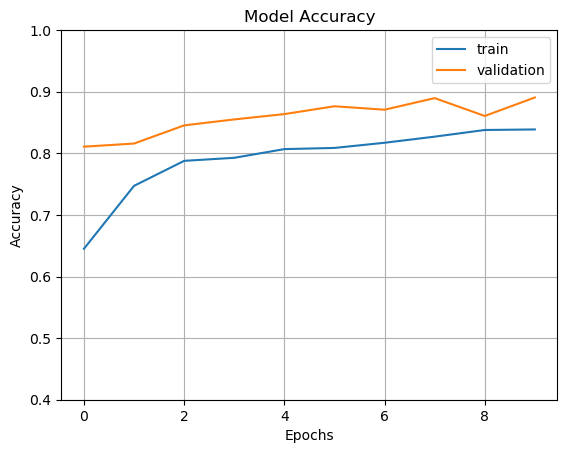

In [38]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

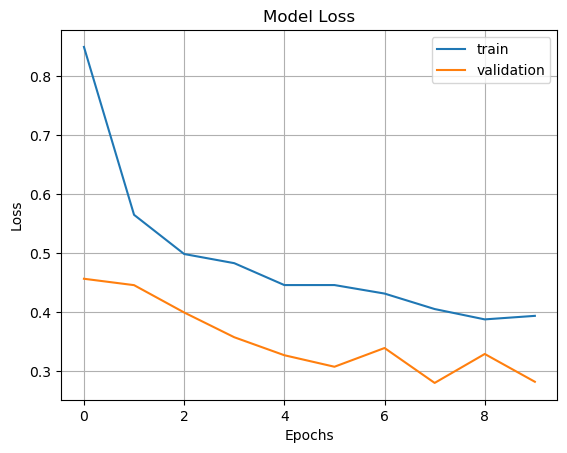

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [51]:
resnet_model.save('/home/vignesh/Transfer-Learning-ResNet-Keras/resnet_model.h5')

/home/vignesh/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Making Predictions

In [ ]:
# Assuming 'model' is your trained ResNet50 model and you have a test set (x_test, y_test)

# Make predictions on the test set
predictions = resnet_model.predict(x_test)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Assuming y_test is a one-hot encoded for multi-class classification, convert it to class indices
true_classes = np.argmax(y_test, axis=1)

# Calculate the accuracy
accuracy = np.mean(predicted_classes == true_classes)

print(f"Model accuracy on test set: {accuracy * 100:.2f}%")


In [55]:
# import cv2
# import csv
# # Load your model
# # model = load_model('path_to_your_model.h5')

# # Directory containing images
# folder_path = 'images/20'

# # Define image dimensions (should match your model's input size)
# img_height, img_width = 150, 150  # Example dimensions for ResNet

# # Placeholder for storing results
# results = []

# # Iterate over all files in the directory
# for filename in os.listdir(folder_path):
#     if filename.endswith(".png"):  # Add other file types if needed
#         # Construct full file path
#         file_path = os.path.join(folder_path, filename)
        
#         # Read and preprocess the image
#         image = cv2.imread(file_path)
#         image_resized = cv2.resize(image, (img_height, img_width))
#         image = np.expand_dims(image_resized, axis=0)  # Add batch dimension
        
#         # Predict
#         prediction = resnet_model.predict(image)
#         output_class=class_names[np.argmax(prediction)]
        
#         # Store the filename and prediction
#         results.append([filename, output_class])  # Adjust depending on your model's output

# # Write results to CSV
# with open('/home/vignesh/Transfer-Learning-ResNet-Keras/predictions.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["Filename", "Prediction"])
#     writer.writerows(results)

# print("Predictions saved to CSV.")

1/1 [==============================] - 0s 34ms/step
Predictions saved to CSV.


In [57]:
import cv2
import time
image=cv2.imread(r'/home/vignesh/Transfer-Learning-ResNet-Keras/semisharp.jpeg')
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
start_time = time.time()
# print(image.shape)
pred=resnet_model.predict(image)
end_time = time.time()
runtime = end_time - start_time
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)
print(f"this took {runtime}ms")


1/1 [==============================] - 0s 33ms/step
The predicted class is 20
this took 0.058539628982543945ms
